### **Etapa 6**

1. Es muy importante para la empresa, dado que se trabaja
con muchos productos importados, entender algunas
variables que provocan fluctuaciones en la demanda.
Como primera medida, se solicita crear un modelo que
tenga la capacidad de predecir el valor del dólar, lo cual
sería muy útil como información para la toma de
decisiones

In [82]:
import pandas as pd
import numpy as np
np.random.seed(4)
import matplotlib.pyplot as plt
import seaborn as sns

In [83]:
data = pd.read_excel('Datasets/tipos-de-cambio-historicos.xlsx', index_col='indice_tiempo', parse_dates=['indice_tiempo'])
data = data[['dolar_estadounidense']]
data.tail()

,dolar_estadounidense
indice_tiempo,
2021-09-26,98.56
2021-09-27,98.63
2021-09-28,98.66
2021-09-29,98.72
2021-09-30,98.74


Cramos una funcion para graficar las predicciones

In [84]:
def graficar_predicciones(real, prediccion):
    plt.plot(real[0:len(prediccion)],color='red', label='Valor real')
    plt.plot(prediccion, color='blue', label='Valor predicho')
    plt.ylim(1.1 * np.min(prediccion)/2, 1.1 * np.max(prediccion))
    plt.xlabel('Tiempo')
    plt.ylabel('Valor del Dólar')
    plt.legend()
    plt.show()

In [85]:
data.head()

,dolar_estadounidense
indice_tiempo,
1970-01-05,NaN
1970-01-06,NaN
1970-01-07,NaN
1970-01-08,NaN
1970-01-09,NaN


In [86]:
data.dropna(inplace = True)

Verificamos que no tenemos NaN

In [87]:
data.isna().value_counts()

dolar_estadounidense
False                   10858
dtype: int64

Vamos a usar los datos < a año = 2020 para train y los > año = 2020 para validacion

In [88]:
set_entrenamiento = data[:'2020'].iloc[:,0:1]
set_validacion = data['2021':].iloc[:,0:1]

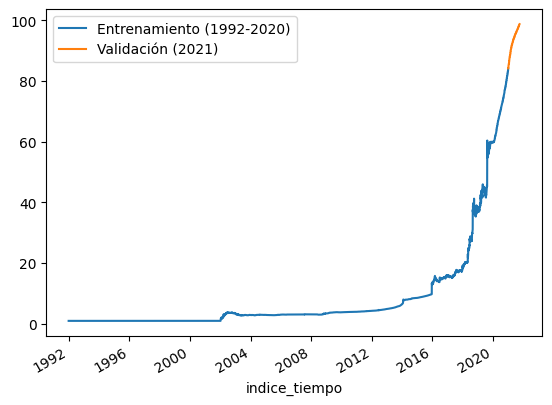

In [89]:
set_entrenamiento['dolar_estadounidense'].plot(legend=True)
set_validacion['dolar_estadounidense'].plot(legend=True)
plt.legend(['Entrenamiento (1992-2020)', 'Validación (2021)'])
plt.show()

In [90]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))

In [91]:
sc = MinMaxScaler(feature_range=(0,1))
set_entrenamiento_escalado = sc.fit_transform(set_entrenamiento)

La red LSTM tendrá como entrada "time_step" datos consecutivos, y como salida 1 dato (la predicción a partir de esos "time_step" datos). 

Se conformará de esta forma el set de entrenamiento

In [92]:
time_step = 30
X_train = []
Y_train = []
m = len(set_entrenamiento_escalado)

for i in range(time_step,m):
    # X: bloques de "time_step" datos: 0-time_step, 1-time_step+1, 2-time_step+2, etc
    X_train.append(set_entrenamiento_escalado[i-time_step:i,0])

    # Y: el siguiente dato
    Y_train.append(set_entrenamiento_escalado[i,0])

In [98]:
X_train, Y_train = np.array(X_train), np.array(Y_train)

In [93]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.layers import Dense, LSTM

In [99]:
dim_entrada = (X_train.shape[1],1)
dim_salida = 1
na = 30

modelo = keras.Sequential()
modelo.add(LSTM(units=na, input_shape=dim_entrada))
modelo.add(Dense(units=dim_salida))
modelo.compile(optimizer='rmsprop', loss='mse')
modelo.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30)                3840      
                                                                 
 dense_4 (Dense)             (None, 1)                 31        
                                                                 
Total params: 3,871
Trainable params: 3,871
Non-trainable params: 0
_________________________________________________________________


In [100]:
modelo.fit(X_train,Y_train,epochs=20,batch_size=180)

Epoch 1/20
59/59 [==============================] - 3s 13ms/step - loss: 0.0053
Epoch 2/20
59/59 [==============================] - 1s 13ms/step - loss: 8.7685e-05
Epoch 3/20
59/59 [==============================] - 1s 13ms/step - loss: 9.3969e-05
Epoch 4/20
59/59 [==============================] - 1s 12ms/step - loss: 7.4076e-05
Epoch 5/20
59/59 [==============================] - 1s 13ms/step - loss: 7.5929e-05
Epoch 6/20
59/59 [==============================] - 1s 14ms/step - loss: 7.1986e-05
Epoch 7/20
59/59 [==============================] - 1s 13ms/step - loss: 6.2070e-05
Epoch 8/20
59/59 [==============================] - 1s 14ms/step - loss: 6.0884e-05
Epoch 9/20
59/59 [==============================] - 1s 17ms/step - loss: 5.9321e-05
Epoch 10/20
59/59 [==============================] - 1s 17ms/step - loss: 5.7470e-05
Epoch 11/20
59/59 [==============================] - 1s 16ms/step - loss: 5.1240e-05
Epoch 12/20
59/59 [==============================] - 1s 16ms/step - loss: 5.28

In [101]:
x_test = set_validacion.values
x_test = sc.transform(x_test)

c:\Users\Emanu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [102]:
X_test = []
for i in range(time_step,len(x_test)):
    X_test.append(x_test[i-time_step:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

In [103]:
prediccion = modelo.predict(X_test)
prediccion = sc.inverse_transform(prediccion)

8/8 [==============================] - 1s 5ms/step


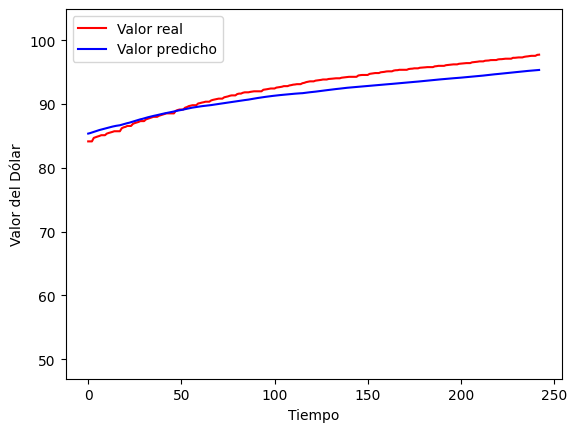

In [104]:
graficar_predicciones(set_validacion.values,prediccion)

In [105]:
modelo.save('lstm_pred_dolar.h5')